# Master's Thesis - Quantum Computing in Electronics Design - Demo

This is a demo for presenting the Master's Thesis "Quantum Computing in Electronics Design".

Universidad Politécnica de Madrid. Master in Quantum Computing Technologies (2023/2024)

Author: Javier Parra Paredes

Director: Rafael Martín-Cuevas Redondo

## 1. Import Libraries and D-Wave Token

Python version used: 3.10.13

requirements.txt file attached. For full information (pip freeze), see requirements_all.txt

D-Wave Token information shall be saved in a file called "dwave_token.txt" at the same level of this Jupyter notebook

In [1]:
from qubo_formulation import qubo_formulation
from helpers.variables import get_qubits_per_variable
from modified_nodal_analysis.mna_matrix_generator import MnaMatrixGenerator
from helpers.constants import LinearCircuitSolver, AnnealerSolution
from helpers.linear_solver import get_solution, get_results, get_expected_results_from_file, get_error_lsb_wrt_expected_results, plot_errors
from fujitsu_tools.fujitsu_tools import TemperatureMode, AutoTuningMode, GraphicsDetailMode
from helpers import demo_notebook_widgets
from dadk.QUBOSolverCPU import *
import time
import ipywidgets as widgets
import os

## 2. Selection of Electronic Circuit under test

### 2.1 Selection of Test Circuit

Select the electronic circuit to be tested: TEST_CIRCUIT_1, TEST_CIRCUIT_2, TEST_CIRCUIT_3, TEST_CIRCUIT_4 

In [2]:
test_circuit_widget = demo_notebook_widgets.TestCircuitWidget()

########################### Selection of Test Circuit ###########################


RadioButtons(description='Electronic circuit under test:', options=('TEST_CIRCUIT_1', 'TEST_CIRCUIT_2', 'TEST_…

### 2.2 Test Circuit Schematic  (in LTSpice)

In [3]:
test_circuit_path = LinearCircuitSolver.TestCircuits.get_test_circuit_path(test_circuit_widget.test_circuit_widget.value)
test_circuit_widget.show_circuit(test_circuit_path=test_circuit_path)

This is the schematic of the electronic circuit under test: TEST_CIRCUIT_1


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\x9a\x00\x00\x02F\x08\x06\x00\x00\x00:~\xfak\x00\…

### 2.3 Netlist in SPICE format  (obtained by LTSpice)

In [4]:
test_circuit_widget.show_netlist(test_circuit_path=test_circuit_path)

This is the netlist information in SPICE format of the electronic circuit under test: TEST_CIRCUIT_1


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00t\x00\x00\x00\x95\x08\x06\x00\x00\x00\x89\x82\xde…

### 2.4 Theoretical Results (obtained by LTSpice)

The theoretical solutions provided by LTSpice. The variables to be solved below are marked in blue (these are the variables obtained with Modified Nodal Analysis below). The rest of variables could be solved directly from the information obtained of the solution.

In [5]:
test_circuit_widget.show_solutions(test_circuit_path=test_circuit_path)

These are the theoretical solutions obtained by LTSpice of the electronic circuit under test: TEST_CIRCUIT_1


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01f\x00\x00\x00v\x08\x06\x00\x00\x00\xfb\x8799\x00\…

## 3. Modified Nodal Analysis

Modified Noda Analysis, based on https://github.com/Tiburonboy/Symbolic-modified-nodal-analysis converts the electronic circuit from SPICE to a matrix form:

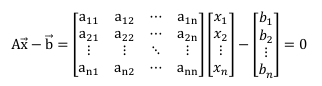

In [6]:
"""
######################## Modified Nodal Analysis ######################################################################
"""
time_start_global = time.time()
mna_matrix_gen = MnaMatrixGenerator()
b_matrix, x_matrix, a_matrix, df, symbol_value_dict = mna_matrix_gen.get_a_b_x_matrix(netlist_filename=test_circuit_path)

print("b vector (constants):")
print(b_matrix)
print("\n")
print("x vector (variables):")
print(x_matrix)
print("\n")
print("A matrix:")
print(a_matrix)
print("\n")
print("Known data (components info such as resistors, voltage, current source values, etc:")
print(symbol_value_dict)
print("\n")

a_matrix = np.asarray(a_matrix.subs(symbol_value_dict))
b_matrix = [expr.subs(symbol_value_dict) for expr in b_matrix]

# Get expected results from file
test_circuit_solution_file = LinearCircuitSolver.TestCircuits.get_test_circuit_solution_file(test_circuit_widget.test_circuit_widget.value)
expected_results_dict = get_expected_results_from_file(os.path.join(os.path.dirname(test_circuit_path), test_circuit_solution_file))
print("Expected results obtained by LTSpice:")
print(expected_results_dict)

b vector (constants):
[0, 0, V1]


x vector (variables):
[V1, V2, I_V1]


A matrix:
Matrix([[1/R1, -1/R1, 1], [-1/R1, 1/R2 + 1/R1, 0], [1, 0, 0]])


Known data (components info such as resistors, voltage, current source values, etc:
{V1: 3.0, R1: 1.0, R2: 0.5}


Expected results obtained by LTSpice:
{V1: 3.0, V2: 1.0, I_V1: -2.0}


## 4. QUBO Formulation

### 4.1 Selection of Method

Select the method to be used:
- Method 1 or METHOD_WITHOUT_SIGN: Same number of qubits for positive and negative values
- Method 2 or METHOD_WITH_SIGN: one qubit dedicated to the sign and the rest of qubits for absolute value

In [7]:
method_widget = demo_notebook_widgets.MethodWidget()

RadioButtons(description='Method:', options=('METHOD_WITHOUT_SIGN', 'METHOD_WITH_SIGN'), style=DescriptionStyl…

### 4.2 Number of qubits for integer and fractional parts selection

For each variable, the number of qubits for the integer and fractional parts shall be selected. (Range for each part: 0...10 qubits)

In [8]:
numer_of_qubits_widgets = demo_notebook_widgets.NumberOfQubits()

IntSlider(value=2, continuous_update=False, description='Number of qubits for Integer part:', layout=Layout(wi…

IntSlider(value=2, continuous_update=False, description='Number of qubits for Fractional part:', layout=Layout…

Get the selected values for method, and number of qubits from Widgets

In [9]:
method = method_widget.method_widget.value
number_of_integer_qubits = numer_of_qubits_widgets.number_of_integer_qubits_widget.value
number_of_fractional_qubits = numer_of_qubits_widgets.number_of_fractional_qubits_widget.value

According to selected number of qubits for integer and fractional part, a dictionary is created for each variable. In this work, the number of qubits is the same for all the variables.

In [10]:
# Establish the number of integer and fractional qubits per each variable
num_qubits_dict = {}
for i in range(0, len(x_matrix)):
    dict_aux = {"INTEGER": number_of_integer_qubits, "FRACTIONAL": number_of_fractional_qubits}
    num_qubits_dict[x_matrix[i]] = dict_aux

Get QUBO matrix

In [11]:
qubit_list_per_variable_dict, number_qubits_used = get_qubits_per_variable(list_of_variables=x_matrix, method=method, num_qubits_dict=num_qubits_dict)

# QUBO Matrix is generated
qubo_matrix = qubo_formulation.get_qubo_matrix(method=method, list_of_variables=x_matrix,
                                               num_qubits_dict=num_qubits_dict,
                                               a_matrix=a_matrix, b_matrix=b_matrix)

# QUBO Matrix Q is:
[[ -3.  12.   0.   0.  -8. -16.   8.  16.   2.   4.  -2.  -4.]
 [  0.   0.   0.   0. -16. -32.  16.  32.   4.   8.  -4.  -8.]
 [  0.   0.   9.  12.   8.  16.  -8. -16.  -2.  -4.   2.   4.]
 [  0.   0.   0.  24.  16.  32. -16. -32.  -4.  -8.   4.   8.]
 [  0.   0.   0.   0.  10.  40.   0.   0.  -2.  -4.   2.   4.]
 [  0.   0.   0.   0.   0.  40.   0.   0.  -4.  -8.   4.   8.]
 [  0.   0.   0.   0.   0.   0.  10.  40.   2.   4.  -2.  -4.]
 [  0.   0.   0.   0.   0.   0.   0.  40.   4.   8.  -4.  -8.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.   4.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   4.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   4.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   4.]]


## 5. Annealer Solver

### 5.1 Selection of Annealer solver

Select the annealer solver to be used:

- D-Wave Simulator (DWAVE_SIM)
- D-Wave Hybrid Solver (DWAVE_HYBRID_SOLVER)
- D-Wave QPU (DWAVE_QPU)
- Fujitsu Digital Annealer (Simulator) (FUJITSU_SIM)

In [12]:
annealer_solver_widget = demo_notebook_widgets.AnnealerSolver()

RadioButtons(description='Annealer Solver:', options=('DWAVE_SIM', 'DWAVE_HYBRID_SOLVER', 'DWAVE_QPU', 'FUJITS…

### 5.2 Configuration of Specific Quantum Annealer / Digital Annealer / Simulator Parameters

In [13]:
annealer_solver_parameters = demo_notebook_widgets.AnnealerSolverParameters(annealer_solver=annealer_solver_widget.annealer_solver_widget.value)

D-Wave QPU Parameters:


IntSlider(value=500, continuous_update=False, description='Number of Reads:', layout=Layout(width='50%'), max=…

IntSlider(value=10, continuous_update=False, description='Chain Strength:', layout=Layout(width='50%'), max=10…

IntSlider(value=20, continuous_update=False, description='Annealing Time (us):', layout=Layout(width='50%'), m…

In [14]:
annealer_solver = annealer_solver_widget.annealer_solver_widget.value

if annealer_solver == AnnealerSolution.FUJITSU_SIM:
    num_reads = annealer_solver_parameters.number_of_reads_fujitsu_widget.value
elif annealer_solver == AnnealerSolution.DWAVE_HYBRID_SOLVER:
    num_reads = 1
else:
    num_reads = annealer_solver_parameters.number_of_reads_dwave_widget.value

# FUJITSU Parameters
fujitsu_number_iterations = annealer_solver_parameters.number_of_iterations_fujitsu_widget.value
fujitsu_temperature_start = annealer_solver_parameters.start_temperature_fujitsu_widget.value
fujitsu_temperature_end = annealer_solver_parameters.end_temperature_fujitsu_widget.value
fujitsu_temperature_mode = TemperatureMode.get_temperature_mode_int(annealer_solver_parameters.temperature_mode_fujitsu_widget.value)
fujitsu_temperature_interval = annealer_solver_parameters.temperature_interval_fujitsu_widget.value

fujitsu_offset_increase_rate = annealer_solver_parameters.offset_increase_rate_fujitsu_widget.value
fujitsu_scaling_bit_precision = annealer_solver_parameters.number_of_bits_scaling_fujitsu_widget.value
fujitsu_auto_tuning = AutoTuningMode.get_auto_tuning_mode_int(annealer_solver_parameters.auto_tuning_mode_fujitsu_widget.value)
fujitsu_graphics = GraphicsDetailMode.get_graphics_detail_int(annealer_solver_parameters.graphics_detail_mode_fujitsu_widget.value)

# DWAVE Parameters
dwave_chain_strength = annealer_solver_parameters.chain_strength_dwave_widget.value
dwave_annealing_time_us = annealer_solver_parameters.annealing_time_us_dwave_widget.value

### 5.3 Solutions retrieval

In [15]:
# QUBO problem is solved by chosen annealer solution
time_start_solver = time.time()
response = get_solution(annealer_solution=annealer_solver, number_qubits_used=number_qubits_used,
                        qubo_matrix=qubo_matrix, num_reads=num_reads,
                        dwave_chain_strength=dwave_chain_strength,
                        dwave_annealing_time_us=dwave_annealing_time_us,
                        fujitsu_number_iterations=fujitsu_number_iterations,
                        fujitsu_temperature_start=fujitsu_temperature_start,
                        fujitsu_temperature_end=fujitsu_temperature_end,
                        fujitsu_temperature_mode=fujitsu_temperature_mode,
                        fujitsu_temperature_interval=fujitsu_temperature_interval,
                        fujitsu_offset_increase_rate=fujitsu_offset_increase_rate,
                        fujitsu_scaling_bit_precision=fujitsu_scaling_bit_precision,
                        fujitsu_auto_tuning=fujitsu_auto_tuning,
                        fujitsu_graphics=fujitsu_graphics)

time_end_solver = time.time()

Serving Inspector on http://127.0.0.1:18000/?problemId=89f4c1e3-81e5-4e12-ba27-c1c9ae5334ee

   q1 q10 q11 q12 q2 q3 q4 q5 q6 q7 q8 q9 energy num_oc. chain_b.
0   1   0   0   1  1  0  0  1  0  0  0  0   -9.0     260 0.083333
3   1   0   1   0  1  0  0  1  0  0  0  0   -8.0      23 0.083333
4   1   0   1   1  1  0  0  1  0  0  0  0   -8.0      33 0.083333
5   0   0   1   0  1  0  0  1  0  0  0  0   -7.0      11 0.083333
9   0   0   0   1  1  0  0  1  0  0  0  0   -6.0      10      0.0
12  0   0   0   0  1  0  0  1  0  0  0  0   -6.0       1 0.083333
1   1   0   0   0  1  0  0  1  0  0  0  0   -5.0      33 0.083333
2   1   0   0   1  1  0  0  1  0  0  0  1   -4.0      46 0.083333
13  1   0   1   0  0  0  0  0  0  0  0  0   -4.0       1      0.0
14  0   0   1   0  1  0  0  1  0  0  0  1   -4.0       5      0.0
16  0   0   0   1  1  0  0  0  0  0  0  0   -4.0       6      0.0
8   1   0   1   0  1  0  0  1  0  0  0  1   -3.0       7 0.083333
10  1   0   1   1  1  0  0  1  0  0  0  1   -3.0       7 0.083333
17  0   0   1   1  1  0  0  1  0  0  0  0   -3.0       2 0.083333
18  0   0 

## 6. PostProcess obtained solutions

This section converts the data returned by the annealer solver to the values of the variables

In [16]:
# Postprocess results
data = get_results(annealer_solution=annealer_solver, x_matrix=x_matrix, method=method, response=response,
                   num_qubits_dict=num_qubits_dict)

time_end_global = time.time()

print("################# Postprocessed data (raw) ###########################")
print(data)

################# Postprocessed data (raw) ###########################
{'result_1': {V1: 3, V2: 1, I_V1: -2, 'occurrences': 260, 'energy': -9.0}, 'result_2': {V1: 3, V2: 1, I_V1: -1, 'occurrences': 23, 'energy': -8.0}, 'result_3': {V1: 3, V2: 1, I_V1: -3, 'occurrences': 33, 'energy': -8.0}, 'result_4': {V1: 2, V2: 1, I_V1: -1, 'occurrences': 11, 'energy': -7.0}, 'result_5': {V1: 2, V2: 1, I_V1: -2, 'occurrences': 10, 'energy': -6.0}, 'result_6': {V1: 2, V2: 1, I_V1: 0, 'occurrences': 1, 'energy': -6.0}, 'result_7': {V1: 3, V2: 1, I_V1: 0, 'occurrences': 33, 'energy': -5.0}, 'result_8': {V1: 3, V2: 1, I_V1: -1, 'occurrences': 46, 'energy': -4.0}, 'result_9': {V1: 2, V2: 0, I_V1: -2, 'occurrences': 6, 'energy': -4.0}, 'result_10': {V1: 2, V2: 1, I_V1: 0, 'occurrences': 5, 'energy': -4.0}, 'result_11': {V1: 1, V2: 0, I_V1: -1, 'occurrences': 1, 'energy': -4.0}, 'result_12': {V1: 2, V2: 1, I_V1: -1, 'occurrences': 5, 'energy': -3.0}, 'result_13': {V1: 2, V2: 1, I_V1: 1, 'occurrences': 4, '

In [17]:
print("################# Timing Performance ###########################")
print("Overall Time: " + str(time_end_global-time_start_global))
print("Solver processing Time: " + str(time_end_solver-time_start_solver))

################# Timing Performance ###########################
Overall Time: 54.3672354221344
Solver processing Time: 18.587727069854736


################# Error in % / Difference in LSBs with respect to Theoretical value ###########################
 - Absolute Error of each variable with respect to theoretical result : {V1: 0.0, V2: 0.0, I_V1: 0.0}
 - Error of each variable in % with respect to theoretical result : {V1: 0.0, V2: 0.0, I_V1: -0.0}
 - Difference of LSBs of each variable with respect to theoretical result : {V1: 0, V2: 0, I_V1: 0}
################# Plot errors in % and LSBs ###########################


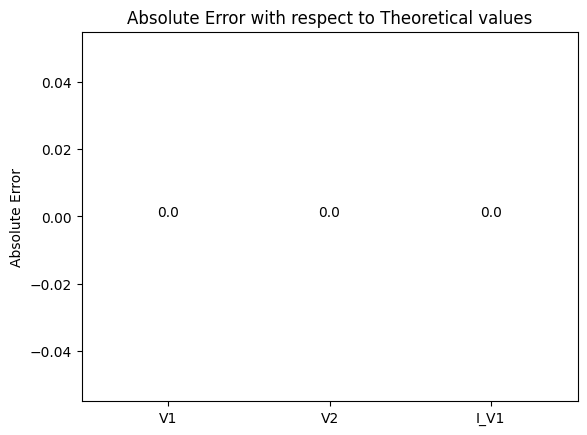

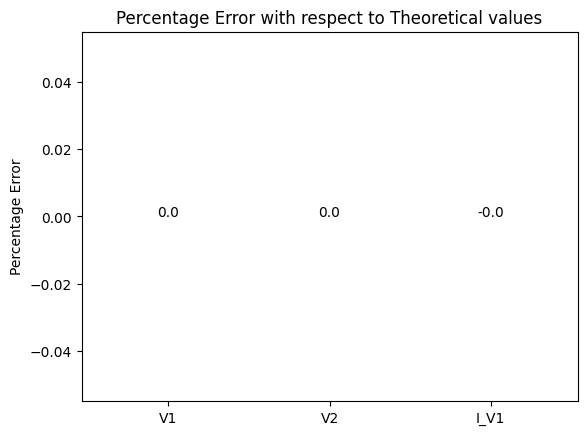

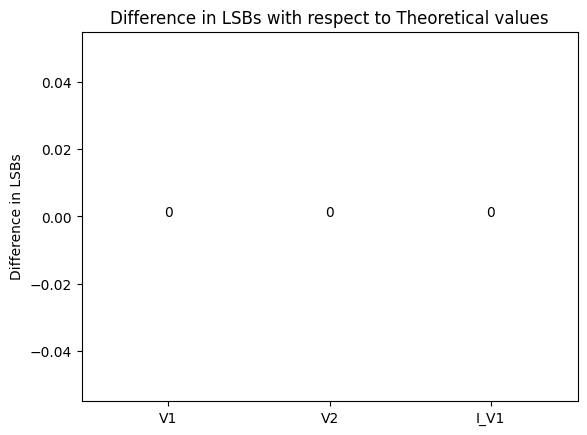

In [18]:
# Calculate error of each variable with respect to theoretical value
print("################# Error in % / Difference in LSBs with respect to Theoretical value ###########################")
absolute_error_dict, percentage_error_dict, lsb_dict = get_error_lsb_wrt_expected_results(expected_results_dict=expected_results_dict, data_dict=data["result_1"], num_qubits_dict=num_qubits_dict)
print(" - Absolute Error of each variable with respect to theoretical result : " + str(absolute_error_dict))
print(" - Error of each variable in % with respect to theoretical result : " + str(percentage_error_dict))
print(" - Difference of LSBs of each variable with respect to theoretical result : " + str(lsb_dict))

# Plot errors / LSBs
print("################# Plot errors in % and LSBs ###########################")
plot_errors(absolute_error_dict, title="Absolute Error")
plot_errors(percentage_error_dict, title="Percentage Error")
plot_errors(lsb_dict, title="Difference in LSBs")

In [19]:
# Calculate number of occurrences of best result (minimum energy) with respect to total number of reads
num_occurrences = data['result_1']['occurrences']
ocurrences_percentage = 100*num_occurrences/num_reads
print("Number of occurrences of the best solution (minimum energy) : " + str(num_occurrences))
print("Number of reads : " + str(num_reads))
print("Percentage of occurrences of the best solution (minimum energy): " + str(ocurrences_percentage) + "%")

Number of occurrences of the best solution (minimum energy) : 260
Number of reads : 500
Percentage of occurrences of the best solution (minimum energy): 52.0%


In [20]:
if annealer_solver == AnnealerSolution.FUJITSU_SIM:
    response.display_graphs()